In [40]:
import ujson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from pandas.io.json import json_normalize
from sklearn import linear_model
import json
import ast
import operator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
# from import lightgbm
from sklearn.metrics import mean_squared_error,r2_score


In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# train.head()

In [42]:
# all the functions defined for data cleaning, manipulation, and feature engineering
def str_to_list(x):
    try:
        return ast.literal_eval(x)
    except:
        pass

def genre_decoder(row,genre):
    try:
        value=0
        for dic in row:
            if dic['name'] == genre:
                value=1
                break
        return value   
    except: 
        return 0  
    
def item_in_dict(dict,key):
    try:
        if dict:
            return dict[key] 
    except:
        return 0

def item_in_list_or_not(list_of_dicts,key,item):
    try:
        output=0
        for dict in list_of_dicts:
            if dict[key]== item:
                output=1
                break
        return  output       
    except:
        return  output  
    
def first_in_list_or_not(list_of_dicts,key,item):
    try:
        output=0
        if list_of_dicts[0][key]== item:
            output=1
        return  output       
    except:
        return  output  
    
def get_first_item_in_list(list_of_dicts,key):
    try:
        return  list_of_dicts[0][key]       
    except:
        return 0    
    
def count_items(x):
    try:
        return len(x)
    except:
        return 0
    

In [43]:
# copy train and test dataframes into train2 and test2 dataframes 
train2=train.copy()
train2=train2.drop(columns=['revenue'])
test2=test.copy()
print('list of original features:')
train2.columns

list of original features:


Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

## convert type of categorical columns from str to list using str_to_list function

In [44]:
columns_to_convert=['genres','production_companies','production_countries',
                    'belongs_to_collection','spoken_languages',
                    'homepage','Keywords', 'cast', 'crew']
# convert all the columns with json format, and pass on empty rows 
for column in columns_to_convert:
    try:
        train2[column]=train2[column].apply(str_to_list)
        test2[column]=test2[column].apply(str_to_list)
    except:
        pass

In [45]:
# count the number of characters for selected features, and return 0 for NAN rows
columns_to_count_len=['genres','production_countries','production_companies',
                      'spoken_languages','Keywords', 'cast', 'crew']

for column in columns_to_count_len:
    try:
        train2[column+'_ct']=train2[column].apply(count_items)
        test2[column+'_ct']=test2[column].apply(count_items)
    except:
        train2[column+'_ct']=0
        test2[column+'_ct']=0

In [46]:
# create new column for each genres, 
# genres_list=[]
# df=pd.DataFrame({})
# for row in train2.genres:
#     try:
#         for dic in row:
#             if dic['name'] not in genres_list:
#                 genres_list.append(dic['name'])
#     except:
#         pass

# encode the genres column    
# for genre in genres_list:
#     train2[genre]=train2.genres.apply(lambda x: genre_decoder(x,genre))
#     test2[genre]=test2.genres.apply(lambda x: genre_decoder(x,genre)) 
#     df[genre]=train2.genres.apply(lambda x: genre_decoder(x,genre)) 
# df.head()
#=================================================================================
# creat a new column for the fisrt listed genre
train2['first_genre']=train2['genres'].apply(lambda x: int(get_first_item_in_list(x,'id')))
test2['first_genre']=test2['genres'].apply(lambda x: int(get_first_item_in_list(x,'id')))
#================================================================================
# creat two new columns for countries column: 
# one to check if one of the production countries is US, and the other one if US is listed first     
              
train2['US_or not']=train2['production_countries'].apply(lambda x: item_in_list_or_not(x,'iso_3166_1','US'))
train2['US_is_first']=train2['production_countries'].apply(lambda x: first_in_list_or_not(x,'iso_3166_1','US'))

test2['US_or not']=test2['production_countries'].apply(lambda x: item_in_list_or_not(x,'iso_3166_1','US'))
test2['US_is_first']=test2['production_countries'].apply(lambda x: first_in_list_or_not(x,'iso_3166_1','US'))

#================================================================================
# create a new column to show wether a movie belongs to a collection or not

train2['collection_or not']=train2['belongs_to_collection'].apply(lambda x: 1 if x else 0)
test2['collection_or not']=test2['belongs_to_collection'].apply(lambda x: 1 if x else 0)
#train2[['belongs_to_collection','collection_or not']].head(10)
train2.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries_ct,production_companies_ct,spoken_languages_ct,Keywords_ct,cast_ct,crew_ct,first_genre,US_or not,US_is_first,collection_or not
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",None,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,1,3,1,4,24,72,35,1,1,1
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,1,1,1,4,20,9,35,1,1,1
2,3,None,3300000,"[{'id': 18, 'name': 'Drama'}]",None,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,1,3,1,12,51,64,18,1,1,0
3,4,None,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",None,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,1,0,2,7,7,3,53,0,0,0
4,5,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",None,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,1,0,1,0,4,2,28,0,0,0


# Reyna's part

In [47]:
train2['production_companies'][:3]

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
Name: production_companies, dtype: object

In [48]:
production_co_dict={}
for row in train2['production_companies']:
    try:
        for item in row:
            if item['name'] in production_co_dict.keys():
                production_co_dict[item['name']] += 1
                
            else:
                production_co_dict[item['name']] = 1
                
                
    except:
        pass

In [49]:
production_co_dict['Marvel Productions']

1

In [50]:
sorted_production_co_dict = sorted(production_co_dict.items(), key = operator.itemgetter(1),reverse = True)
top_10_production_companies = [x[0] for x in sorted_production_co_dict][:40]
top_10_production_companies

['Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'Metro-Goldwyn-Mayer (MGM)',
 'New Line Cinema',
 'Touchstone Pictures',
 'Walt Disney Pictures',
 'Columbia Pictures Corporation',
 'TriStar Pictures',
 'Relativity Media',
 'Canal+',
 'United Artists',
 'Miramax Films',
 'Village Roadshow Pictures',
 'Regency Enterprises',
 'BBC Films',
 'Dune Entertainment',
 'Working Title Films',
 'Fox Searchlight Pictures',
 'StudioCanal',
 'Lionsgate',
 'DreamWorks SKG',
 'Fox 2000 Pictures',
 'Summit Entertainment',
 'Hollywood Pictures',
 'Orion Pictures',
 'Amblin Entertainment',
 'Dimension Films',
 'Castle Rock Entertainment',
 'Epsilon Motion Pictures',
 'Morgan Creek Productions',
 'Original Film',
 'Focus Features',
 'Legendary Pictures',
 'Participant Media',
 'Blumhouse Productions',
 'New Regency Pictures',
 'Film4']

### New Column - to see if the movie is made by top 10 movie production companies

(array([  15.,   19.,   20.,   16.,   98.,  213.,  403.,  884., 1047.,
         285.]),
 array([0.        , 0.91817173, 1.83634345, 2.75451518, 3.6726869 ,
        4.59085863, 5.50903035, 6.42720208, 7.3453738 , 8.26354553,
        9.18171726]),
 <a list of 10 Patch objects>)

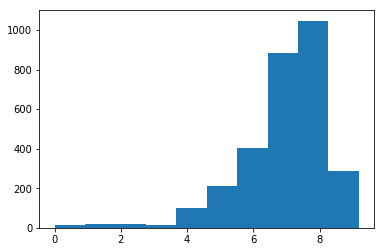

In [51]:
plt.hist(train['revenue'].apply(np.log10))

In [52]:
def production_in_top10(production_comp):
    try:
        for item in production_comp:
            if item['id'] in top_10_production_companies:
                return 1
    except:
        pass
    return 0

In [53]:
## Add the new column to both training and testing set
for df in [train2,test2]:
    df['in_top10_prod'] = df['production_companies'].apply(production_in_top10)
    label_encoder=LabelEncoder().fit(df['in_top10_prod'])
    df['encoded_in_top10_prod'] = label_encoder.transform(df['in_top10_prod'])
    df['encoded_in_top10_prod'] = df['encoded_in_top10_prod'].astype('category')
    df.drop(columns='in_top10_prod',inplace = True)


# code for test set

# test2['in_top10_prod'] = test2['production_companies'].apply(production_in_top10)
# label_encoder=LabelEncoder().fit(test2['in_top10_prod'])
# test2['encoded_in_top10_prod'] = label_encoder.transform(test2['in_top10_prod'])
# test2['encoded_in_top10_prod'] = test2['encoded_in_top10_prod'].astype('category')
# test2.drop(columns='in_top10_prod',inplace = True)

In [54]:
train2

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_companies_ct,spoken_languages_ct,Keywords_ct,cast_ct,crew_ct,first_genre,US_or not,US_is_first,collection_or not,encoded_in_top10_prod
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",None,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,3,1,4,24,72,35,1,1,1,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,1,1,4,20,9,35,1,1,1,0
2,3,None,3300000,"[{'id': 18, 'name': 'Drama'}]",None,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,3,1,12,51,64,18,1,1,0,0
3,4,None,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",None,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,2,7,7,3,53,0,0,0,0
4,5,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",None,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,1,0,4,2,28,0,0,0,0
5,6,None,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",None,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,0,1,0,4,11,16,0,0,0,0
6,7,None,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",None,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,2,1,0,14,77,27,1,1,0,0
7,8,None,0,"[{'id': 99, 'name': 'Documentary'}]",None,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,0,2,7,4,1,99,0,0,0,0
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",None,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,3,1,4,12,8,28,1,1,1,0
9,10,None,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",None,tt0310281,en,A Mighty Wind,"In ""A Mighty Wind"", director Christopher Guest...",4.672036,...,1,1,2,20,11,35,1,1,0,0


In [55]:
print(list(train2.columns))

['id', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'genres_ct', 'production_countries_ct', 'production_companies_ct', 'spoken_languages_ct', 'Keywords_ct', 'cast_ct', 'crew_ct', 'first_genre', 'US_or not', 'US_is_first', 'collection_or not', 'encoded_in_top10_prod']


# TensorFlow Try

### First, flatten out all of the dictionary-type of columns

In [60]:
#create new column for each genre and country, 
for column in ['genres','production_countries']:
    column_list=[]
    df=pd.DataFrame({})
    for row in train2[column]:
        try:
            for dic in row:
                if dic['name'] not in column_list:
                    column_list.append(dic['name'])
        except:
            pass

    #encode the genres column and country    
    for item in column_list:
        train2[item]=train2[column].apply(lambda x: genre_decoder(x,item)).astype('category')
        test2[item]=test2[column].apply(lambda x: genre_decoder(x,item)).astype('category')
        df[item]=train2.genres.apply(lambda x: genre_decoder(x,item)).astype('category')
train2['if_belongs_to_collection'] = np.where(train2['belongs_to_collection'].isnull(),0,1)
test2['if_belongs_to_collection'] = np.where(test2['belongs_to_collection'].isnull(),0,1)

#Columns to be removed
to_remove = ['id','belongs_to_collection','genres','homepage','imdb_id','overview','original_title'
            ,'poster_path','production_companies','production_countries','release_date','spoken_languages_ct',
            'tagline','Keywords','cast','crew','spoken_languages','title','original_language','status']

train_reyna = train2.drop(columns = to_remove)

#label_encoder = LabelEncoder().fit(train_reyna['status'])
#train_reyna['status'] = label_encoder.transform(train_reyna['status'])
#test2['status']= label_encoder.transform(test2['status'])

for df in [train_reyna,test2]:
    df['runtime'].fillna(df['runtime'].mean(),inplace = True)


#train_reyna['original_language'].astype('category')
y = train['revenue'].apply(lambda x: x/10**4)
X_train, X_test,y_train, y_test = train_test_split(train_reyna,y,test_size = 0.2)
models = []
for model in [linear_model.LinearRegression(),
              linear_model.Lasso(alpha=0.1),
              RandomForestRegressor(n_estimators=500),
             GradientBoostingRegressor(),
             ]:
    model.fit(X_train,y_train)
    models.append(model)
    
    print('Train Set',str(model).split("(")[0],model.score(X_train,y_train))
    print('Test Set',str(model).split("(")[0],model.score(X_test,y_test))
    print(mean_squared_error(y_test,model.predict(X_test)),r2_score(y_test,model.predict(X_test)))
    print('-'*40)

Train Set LinearRegression 0.6568486771014039
Test Set LinearRegression 0.6869676260443017
73814107.95626684 0.6869676260443017
----------------------------------------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Train Set Lasso 0.6568443429358398
Test Set Lasso 0.6869552620288
73817023.43354952 0.6869552620288
----------------------------------------
Train Set RandomForestRegressor 0.9590584317160488
Test Set RandomForestRegressor 0.7278505529915504
64173773.49143776 0.7278505529915504
----------------------------------------
Train Set GradientBoostingRegressor 0.8512739632818038
Test Set GradientBoostingRegressor 0.7184872696550694
66381667.8324938 0.7184872696550694
----------------------------------------


In [61]:

            
model = models[2]
test2['revenue'] = model.predict(test2[X_train.columns].fillna(0))
test2['revenue']=test2['revenue'].apply(lambda x: max(0,x)*10**4)
test2[['id','revenue']].to_csv('test_submission.csv',index = False, header = True)

# CG 's part

# MBBA 's part

# Scale numerical columns

In [ ]:
traintest2 = train2.append(test2,ignore_index= True)
numerical_columns=traintest2.select_dtypes(['int','int64','float']).drop(columns=['id']).columns
ScalerList = []

# Fill runtime NA with the mean
for df in [train2,test2,traintest2]:
    df['runtime'].fillna(df['runtime'].mean(),inplace = True)

# #One Hot Encoding
# onehotencoder = OneHotEncoder().fit(traintest2['first_genre'])
# train2['ecoded_original_language']=o_label_encoder.transform(train2['original_language'])

train3 = train2.copy()
test3 = test2.copy()

for column in numerical_columns:    
    scaler = MinMaxScaler()
    fitted = scaler.fit(traintest2[column].values.reshape(-1,1))
    train3[column] = fitted.transform(train3[column].values.reshape(-1,1))
    test3[column] = fitted.transform(test3[column].values.reshape(-1,1))

# scaler = MinMaxScaler()
# train2_num_scaled = pd.DataFrame(scaler.fit(traintest2[numerical_columns]).transform(train2),traintest2 = columns)
# test2_num_scaled = pd.DataFrame(scaler.fit(traintest2[numerical_columns]).transform(test2),columns = numerical_columns)
train3.head()



In [ ]:

# #scale numerical columns
# numerical_columns=traintest2.select_dtypes(['int','int64','float']).drop(columns=['id']).columns
# print(numerical_columns)

# for column in numerical_columns:
#     train2['s_'+column]=train2[column].apply(lambda x: (x-train2[column].min())/(train2[column].max()-train2[column].min()))
#     test2['s_'+column]=test2[column].apply(lambda x: (x-test2[column].min())/(test2[column].max()-test2[column].min()))
    

In [ ]:
# train2_temp=train2[['genres_ct',
#        'production_countries_ct', 'production_companies_ct',
#        'spoken_languages_ct', 'Keywords_ct', 'cast_ct', 'crew_ct',
#        'first_genre', 'US_or not', 'US_is_first', 'collection_or not',
#        's_budget', 's_popularity', 's_runtime', 's_genres_ct',
#        's_production_countries_ct', 's_production_companies_ct',
#        's_spoken_languages_ct', 's_Keywords_ct', 's_cast_ct', 's_crew_ct',
#        's_first_genre', 's_US_or not', 's_US_is_first', 's_collection_or not','encoded_in_top10_prod']]

# train2_temp[train2_temp.isnull().any(axis=1)]


In [ ]:
## there are two rows with NaN runtime
# train2['s_runtime'].fillna(train2['s_runtime'].mean(),inplace = True)

In [ ]:
train3.columns

In [ ]:
X=train2[['budget','popularity', 'runtime',
        'genres_ct',
       'production_countries_ct', 'production_companies_ct',
       'spoken_languages_ct', 'Keywords_ct', 'cast_ct', 'crew_ct',
       'first_genre', 'US_or not', 'US_is_first', 'collection_or not',
       'encoded_in_top10_prod']]

#Just work with numerical columns
# X = train2['budget'].values.reshape(-1,1)


In [ ]:
y = train['revenue']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42, test_size = 0.2)
# y_scaler=StandardScaler().fit(y_train)
# y_train_scaled=y_scaler.transform(y_train)
# y_test_scaled=y_scaler.transform(y_test)

In [ ]:
for model in [linear_model.LinearRegression(),
              linear_model.Lasso(alpha=0.1),
              RandomForestRegressor(max_depth=2,random_state=2,n_estimators=200),
             LinearSVR(),
             GradientBoostingRegressor(),
             ]:
    model.fit(X_train,y_train)
    print(str(model).split("(")[0],model.score(X_test,y_test))
    print(mean_squared_error(y_test,model.predict(X_test)),r2_score(y_test,model.predict(X_test)))

# rnf=RandomForestRegressor(max_depth=2,random_state=2,n_estimators=200)
# rnf.fit(X_train,y_train)
# rnf.score(X_train,y_train)
# rnf.score(X_test,y_test)

In [ ]:
model=RandomForestRegressor(max_depth=2,random_state=2,n_estimators=200)
model.fit(X,y)
model.feature_importances_


In [ ]:
# So far gradient boosting regressor is doing best. Let's run the test set and submit
model=GradientBoostingRegressor()
model.fit(X,y)

test2['revenue'] = model.predict(test2[X.columns].fillna(0))
test2['revenue']=test2['revenue'].apply(lambda x: max(0,x))
test2[['id','revenue']].to_csv('test_submission.csv',index = False, header = True)

In [ ]:
test2[['id','revenue']].describe()

In [62]:
!kaggle competitions submit -f 'test_submission.csv' -m 'lin model' tmdb-box-office-prediction

100%|██████████████████████████████████████| 99.2k/99.2k [00:02<00:00, 34.5kB/s]
Successfully submitted to TMDB Box Office Prediction

In [ ]:
# list of collections
train2['belongs_to_collection'][:2]
collection_list=['none']
df=pd.DataFrame({})
for row in train2['belongs_to_collection']:
    try:
        for dic in row:
#             print(dic['name'])
            if dic['name'] not in collection_list:
                collection_list.append(dic['name'])
    except:
        pass
len(collection_list)    

In [ ]:
# o_label_encoder=LabelEncoder().fit(train2['original_language'])
# train2['ecoded_original_language']=o_label_encoder.transform(train2['original_language'])


In [ ]:
# o2_label_encoder=LabelEncoder().fit(test2['original_language'])
# test2['ecoded_original_language']=o2_label_encoder.transform(test2['original_language'])


In [ ]:
# o_label_encoder.classes_

In [ ]:
# o2_label_encoder.classes_